## Classification: Part - 02

In [1]:
import torch

In [2]:
!nvidia-smi

Sun Oct  6 15:18:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Data Preparation

In [3]:
import sklearn
from sklearn.datasets import make_circles

n_samples = 1000

x, y = make_circles(
    n_samples,
    noise=0.02,
    random_state=2
)

In [4]:
len(x), len(y)

(1000, 1000)

In [5]:
import pandas as pd

circlesDf = pd.DataFrame({
    "X1": x[:, 0],
    "X2": x[:, 1],
    "label": y
})
circlesDf.head(10)

,X1,X2,label
0,0.862882,0.485915,0
1,-0.752037,0.238496,1
2,-0.278193,-0.731175,1
3,-0.862810,-0.535677,0
4,0.465783,-0.670694,1
5,-0.312597,0.707686,1
6,-0.522709,0.584159,1
7,-0.894216,-0.424991,0
8,0.038095,-0.762451,1
9,-0.931833,-0.264412,0


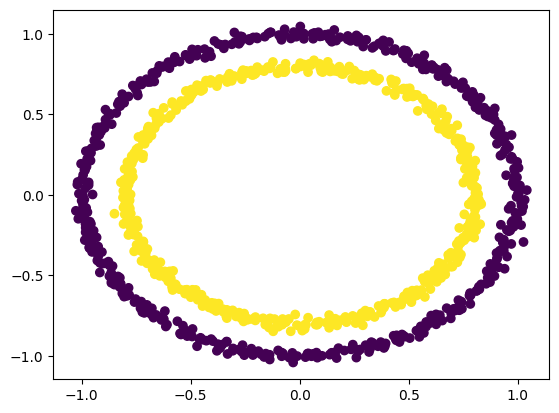

In [6]:
import matplotlib.pyplot as plt

plt.scatter(x=circlesDf["X1"], y=circlesDf["X2"], c=y)

In [7]:
# converting data

x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

x.shape, y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [8]:
# splitting the data in train and test set

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=2)

In [9]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

(torch.Size([900, 2]),
 torch.Size([100, 2]),
 torch.Size([900]),
 torch.Size([100]))

## Building a model: Introducing non linearity

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [11]:
from torch import nn

class CircleModelV3(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    # introducing non linear activation function (relu)
    self.relu = nn.ReLU()

  def forward(self, x):
    # z = self.layer_1(x)
    # z = self.relu(z)
    # z = self.layer_2(z)
    # z = self.relu(z)
    # z = self.layer_3(z)
    # return z
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV3().to(device)
model_3

CircleModelV3(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

## Training and test loop

In [12]:
epochs = 1200

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

x_train = x_train.to(device)
y_train = y_train.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

In [13]:
for epoch in range(epochs):
  model_3.train()

  y_logits = model_3(x_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  loss = loss_fn(y_logits, y_train) # BCE with logits so take logits
  acc = (y_pred == y_train).sum() / len(y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(x_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = (test_pred == y_test).sum() / len(y_test)

  if epoch % 40 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Acc: {acc} | Test Loss: {test_loss} | Test Acc: {test_acc}")

Epoch: 0 | Loss: 0.6983160376548767 | Acc: 0.5011111497879028 | Test Loss: 0.6995561122894287 | Test Acc: 0.4899999797344208
Epoch: 40 | Loss: 0.6930966973304749 | Acc: 0.5233333706855774 | Test Loss: 0.6923521757125854 | Test Acc: 0.5199999809265137
Epoch: 80 | Loss: 0.6920485496520996 | Acc: 0.5166666507720947 | Test Loss: 0.6912632584571838 | Test Acc: 0.5099999904632568
Epoch: 120 | Loss: 0.6911851763725281 | Acc: 0.5188888907432556 | Test Loss: 0.6906618475914001 | Test Acc: 0.5199999809265137
Epoch: 160 | Loss: 0.6902454495429993 | Acc: 0.5266667008399963 | Test Loss: 0.6900115609169006 | Test Acc: 0.5099999904632568
Epoch: 200 | Loss: 0.6892424821853638 | Acc: 0.5311111211776733 | Test Loss: 0.6892221570014954 | Test Acc: 0.5199999809265137
Epoch: 240 | Loss: 0.6881522536277771 | Acc: 0.5333333611488342 | Test Loss: 0.6882683634757996 | Test Acc: 0.5199999809265137
Epoch: 280 | Loss: 0.6869702935218811 | Acc: 0.5388889312744141 | Test Loss: 0.6872225999832153 | Test Acc: 0.52999

In [14]:
import requests

url = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py"

response = requests.get(url)
with open("helper_functions.py", "wb") as f:
    f.write(response.content)

In [15]:
from helper_functions import plot_decision_boundary

## Evaluating

In [16]:
model_3.eval()

with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(x_test))).squeeze()

y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 1., 0., 0., 1., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 1., 0., 0., 1., 0., 1., 0.], device='cuda:0'))

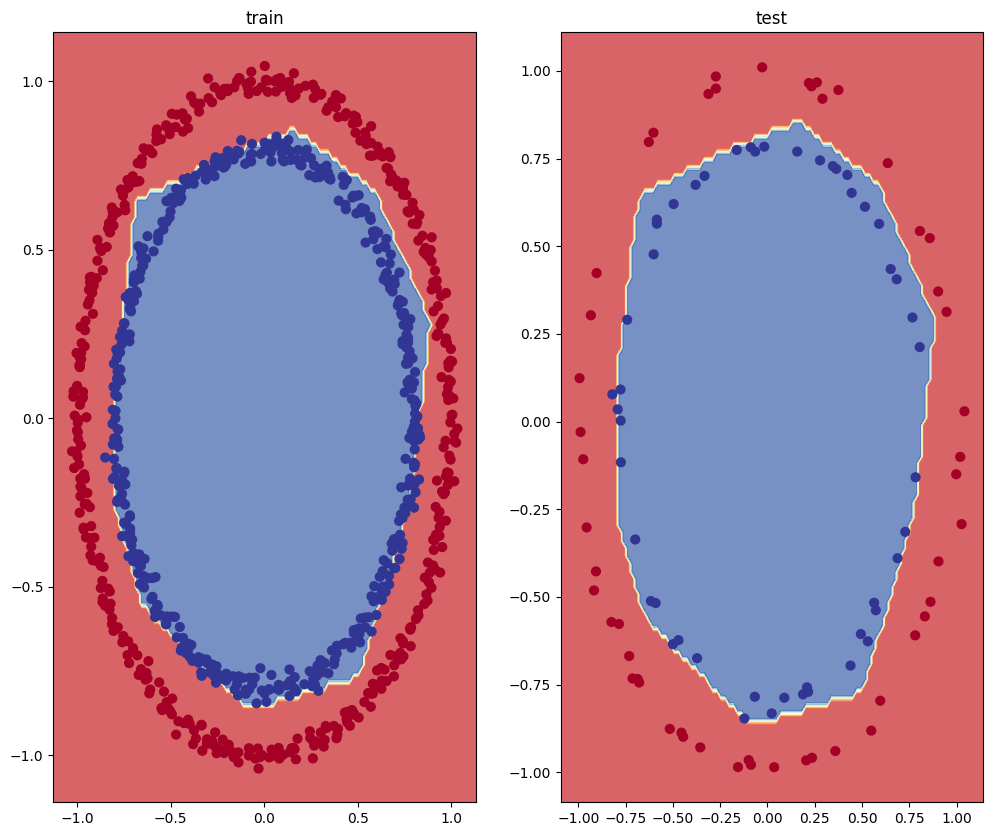

In [19]:
# plotting decision boundary

plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(model_3, x_train, y_train)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_3, x_test, y_test)


In [20]:
model_3.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.8011, -1.4783],
                      [ 0.1861, -0.5062],
                      [ 0.2463,  1.0343],
                      [-0.8075,  1.1814],
                      [ 0.0626, -0.3144],
                      [ 1.0209, -0.4524],
                      [-0.7786,  0.0813],
                      [-1.6519, -1.3861],
                      [-1.0082, -0.4430],
                      [-0.4237, -0.0231]])),
             ('layer_1.bias',
              tensor([-0.2903,  0.8198,  0.0829, -0.3183, -0.3338,  1.0861,  0.7553, -0.2330,
                       1.0991,  0.4160])),
             ('layer_2.weight',
              tensor([[ 0.1904, -0.1397, -0.1411,  0.3997,  0.1367, -0.4620,  0.3494,  0.4243,
                       -0.0553, -0.0648],
                      [-0.3016, -0.0768, -0.2899,  0.1400, -0.0690,  0.2163, -0.1519, -0.3144,
                        0.0483, -0.2983],
                      [ 0.3317, -0.6439,  0.4136,  0.8385, -0.1581, -1.2